In [112]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import numpy as np

img = np.load('../all_sites_data_prepared/pics_data/train_img_m1s1.npy')
resp = np.load('../all_sites_data_prepared/New_response_data/trainRsp_m1s1.npy')
img=np.reshape(img,(34000,1,50,50))
print(img.shape)
print(resp.shape)

(34000, 1, 50, 50)
(34000, 302)


In [113]:
def patchify(images, n_patches):
    n,c,h,w = images.shape
    patches = torch.zeros(n,n_patches**2, h*w//n_patches**2) #(34000, 100,25)
    patch_size = h//n_patches

    for idx,image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:,i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size]
                patches[idx,i*n_patches+j] = patch.flatten()
    return patches

(34000, 1, 50, 50)
(1, 1, 50, 50)


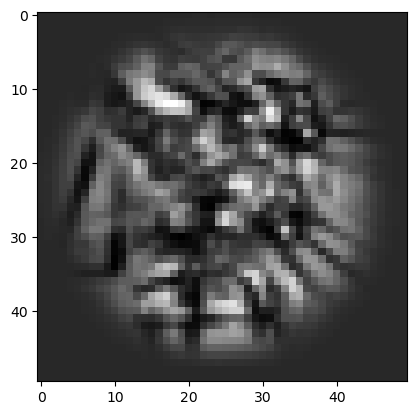

In [114]:
print(img.shape)
test = img[:1] #should be (1,1,50,50)
print(test.shape)
plt.imshow(test[0,0,:,:],cmap="gray")
plt.show()



In [115]:
num_patches = 2
temp = patchify(torch.from_numpy(test),num_patches) #seperate core model uses a 5x5 kernel size
temp.shape

torch.Size([1, 4, 625])

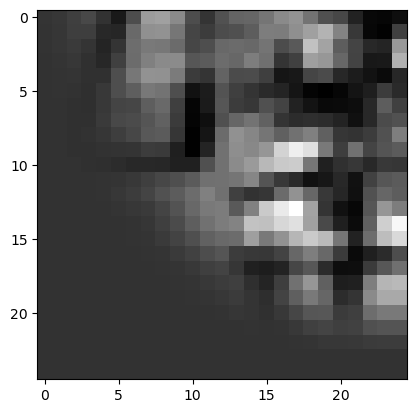

In [71]:
temp = temp.reshape([1,num_patches**2,50//num_patches,50//num_patches])

plt.imshow(temp[0,2,:,:],cmap="gray")
plt.show()

attempt with conv2d


In [72]:
#now with overlaps (1/2 overlap first)
#so for 10x10 of 5x5 it goes images (1,1,50,50) --> image (1,50,50) --> patch (1,5,5) --> patches (1,100,25)
def patchify(images):
    n,c,h,w = images.shape
    conv =  nn.Conv2d(in_channels=c, out_channels=c, kernel_size=(10,10),stride=10)
    patches = conv(images)
    return patches


In [73]:
num_patches = 10
test2 = torch.from_numpy(np.float32(test))
test2

tensor([[[[0.1875, 0.1875, 0.1875,  ..., 0.1875, 0.1875, 0.1875],
          [0.1875, 0.1875, 0.1875,  ..., 0.1875, 0.1875, 0.1875],
          [0.1875, 0.1875, 0.1875,  ..., 0.1875, 0.1875, 0.1875],
          ...,
          [0.1875, 0.1875, 0.1875,  ..., 0.1875, 0.1875, 0.1875],
          [0.1875, 0.1875, 0.1875,  ..., 0.1875, 0.1875, 0.1875],
          [0.1875, 0.1875, 0.1875,  ..., 0.1875, 0.1875, 0.1875]]]])

In [74]:
ps = patchify(test2)
ps.shape

torch.Size([1, 1, 5, 5])

attempt with unfold

In [94]:
x = test2 # batch, c, h, w
kh, kw = 25, 25  # kernel size
dh, dw = 5, 5  # stride
# patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
patches = patches.contiguous().view(patches.size(0), -1, kh, kw)
print(patches.shape)

torch.Size([1, 36, 25, 25])


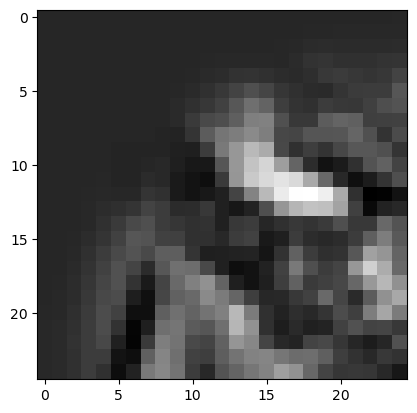

In [97]:
for i in range(1):
    plt.imshow(patches[0,i,:,:],cmap="gray")
    plt.show()

In [99]:
def patchify_overlaps(images,kernel_size=(10,10),stride=(5,5)):
    x = images # batch, c, h, w
    kh, kw = kernel_size  # kernel size
    dh, dw = stride  # stride
    # patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
    patches = patches.contiguous().view(patches.size(0), -1, kh, kw)
    return patches

In [102]:
out = patchify_overlaps(torch.from_numpy(np.float32(img)))
print(out.shape)


torch.Size([34000, 81, 10, 10])


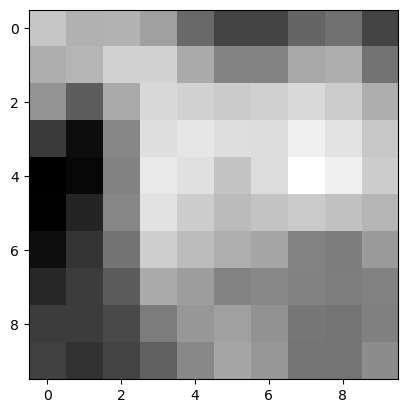

In [110]:
plt.imshow(out[100,13,:,:],cmap="gray")
plt.show()

In [123]:
def patchify_overlaps(images,kernel_size=(10,10),stride=(3,3)):
    x = images # batch, c, h, w
    kh, kw = kernel_size  # kernel size
    dh, dw = stride  # stride
    # patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
    patches = x.unfold(2, kh, dh).unfold(3, kw, dw)
    patches = patches.contiguous().view(patches.size(0), -1, kh, kw)
    return torch.flatten(patches,start_dim=-2, end_dim=-1)
out = patchify_overlaps(torch.from_numpy(np.float32(img)))
print(out.shape)

torch.Size([34000, 196, 100])


In [124]:
a,b,c = (100,(10,10),3)
b

(10, 10)